In this notebook we compare the translational mobility coefficients for a pair of passive spheres for 

 - Superposition/Pystokes
 - 2s (2s - similar to FTS Stokesian dynamics, but without adhoc lubrication effects)
 - 2s, 3t (3t)
 - 2s, 3t, 3a (3a)
 - 2s, 3t, 3a, 3s (long-ranged)
 
 to the exact solution given by **Goldman, Cox and Brenner (1966)** using bipolar coordinates finding exact numerical values for the terminal speed of two spheres sedimenting, later re-used by **Batchelor (1971)**, and also **Ladd (1988)**. 
 
 We also compare $\mu^{RT}$ to the exact solution obtained by Goldman, Cox and Brenner. 

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt

import pystokes
from solveFull import linearSolve_krylov as Full

In [2]:
PI = 3.14159265359

# particle radius, self-propulsion speed, number and fluid viscosity
b, Np, eta = 1.0, 2, 0.1

## passive particle
D0  = 0.      
S0  = 0.

## normalising factor: one-particle mobility
mu0 = 1./(6*PI*eta*b)

The results are compared at the nine fixed ratios $r/b$, where $r$ is the centre-to-centre distance: $2.0,\, 2.0049,\, 2.0907,\, 2.2553,\, 2.6749,\, 3.0862,\, 4.0,\, 6.0,\, 8.0$

In [3]:
rb = np.array([2.0, 2.0049, 2.0907, 2.2553, 2.6749, 3.0862, 4.0, 6.0, 8.0])

___________

### Exact results (normalised by $\mu_0$)

In [4]:
muPara = np.array([1.5500, 1.5494, 1.5376, 1.5160, 1.4662, 1.4236, 1.3472, 1.2427, 1.1847]) #force parallel to line of centers
muPerp = np.array([1.3799, 1.4027, 1.3933, 1.3648, 1.3029, 1.2586, 1.1950, 1.1273, 1.0947]) #force perpendicular to line of centers

In [5]:
2*np.array([1, 1.00245, 1.005, 1.0453, 1.1276, 1.3374, 1.5431]) ##use all but the third one

array([2.    , 2.0049, 2.01  , 2.0906, 2.2552, 2.6748, 3.0862])

In [6]:
##from Goldman, Cox and Brenner Table 6 and 7. corresponding to the distances rb = 2*h/b
Fstar = np.array([0.72469, 0.71292, 0.71771, 0.73271, 0.76751, 0.79454, 0.83680, 0.88709, 0.91348])
Ostar = np.array([0, 7.7176e-2, 9.8065e-2, 9.6285e-2, 7.7524e-2, 6.1575e-2, 3.9075e-2, 1.8473e-2, 1.0703e-2])

##muRT/mu0
muRT = Ostar/(b*Fstar)

## muTT/m0 = 1/Fstar is the same as the above muPerp - check

____________

### PyStokes

In [7]:
pstk = pystokes.unbounded.Rbm(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

pstk_muPara = np.zeros(rb.shape[0])
pstk_muPerp = np.zeros(rb.shape[0])
pstk_muRT   = np.zeros(rb.shape[0])


r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

## parallel
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force parallel to separation - along x axis
        F[i]      = 1.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
    
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
        
    pstk_muPara[k] = v[0]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1
    
## perpendicular
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 1.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    pstk.mobilityTT(v,r,F)
    pstk.mobilityTR(v,r,T)
    pstk.mobilityRT(o,r,F)
    pstk.mobilityRR(o,r,T)
        
    pstk_muPerp[k] = v[4]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    pstk_muRT[k] = abs(o[2])/mu0
    k += 1

In [8]:
pstk_muPara/muPara

array([1.0483871 , 1.04820011, 1.04580903, 1.04084827, 1.02886353,
       1.01996004, 1.00903726, 1.00214885, 1.00071484])

In [9]:
pstk_muPerp/muPerp

array([1.04174216, 1.02383002, 1.01445853, 1.00830671, 1.0027698 ,
       1.00113384, 1.00026151, 1.00001314, 1.00002426])

In [10]:
pstk_muRT[1:]/muRT[1:] ##first entry of muRT is zero, particles don't rotate when touching (really??)

array([1.72359158, 1.25577777, 1.12208591, 1.03775308, 1.01607198,
       1.00383877, 1.00043532, 1.00017226])

______________

## Full solver (2s, 3t, 3a, 3s)

In [11]:
full = Full(b, Np, eta)
## define distances that iterate through rb/2 and forces parallel and perpendicular to these distances 

full_muPara = np.zeros(rb.shape[0])
full_muPerp = np.zeros(rb.shape[0])
full_muRT   = np.zeros(rb.shape[0])


r, F, T, v, o = np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np), np.zeros(3*Np)

S = np.zeros(9*Np)
D = np.zeros(3*Np)

## parallel
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force parallel to separation - along x axis
        F[i]      = 1.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 0.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
    
    full.RBM(v, o, r, F, T, S, D)
        
    full_muPara[k] = v[0]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    k += 1
    
## perpendicular
k=0
for rb_ in rb:
    #separation in x-direction
    r[0] = -rb_/2.
    r[1] =  rb_/2.
    for i in range(Np):
        #force perpendicular to separation - along z axis
        F[i]      = 0.0
        F[i+Np]   = 0.0 
        F[i+2*Np] = 1.0
        
        v[i]      = 0.0
        v[i+Np]   = 0.0
        v[i+2*Np] = 0.0
        
        o[i]      = 0.0
        o[i+Np]   = 0.0
        o[i+2*Np] = 0.0
        
    full.RBM(v, o, r, F, T, S, D)
        
    full_muPerp[k] = v[4]/mu0 ## force is unity, so raw mobility is just velocity. Normalised by one-particle mobility
    full_muRT[k] = abs(o[2])/mu0
    k += 1

In [12]:
full_muPara/muPara

array([1.00064647, 1.00059064, 1.00057118, 1.00051222, 1.00039239,
       1.00027199, 1.00011381, 0.99997923, 0.99996878])

In [13]:
full_muPerp/muPerp

array([1.02490188, 1.00754149, 1.0022084 , 1.00093632, 1.00034076,
       1.00013691, 1.00005197, 0.99999399, 1.00002075])

In [14]:
full_muRT[1:]/muRT[1:]

array([1.39900385, 1.06670176, 1.01162427, 0.99950707, 0.99944754,
       0.99989249, 0.99997251, 1.0000671 ])

________________

## Plotting

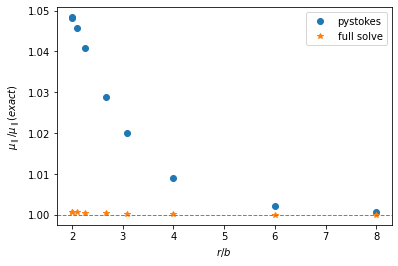

In [15]:
plt.plot(rb, pstk_muPara/muPara, label='pystokes', marker='o', linestyle="None")
# plt.plot(rb, sp_muPara/muPara, label='superposition', marker='^', linestyle="None")
# plt.plot(rb, _2s_muPara/muPara, label='2s', marker='s', linestyle="None")
# plt.plot(rb, _3t_muPara/muPara, label='3t', marker='d', linestyle="None")
# plt.plot(rb, _3a_muPara/muPara, label='3a', marker='+', linestyle="None")
plt.plot(rb, full_muPara/muPara, label='full solve', marker='*', linestyle="None")
plt.axhline(y=1., color='grey', linestyle='--', linewidth=1)
plt.xlabel('$r/b$')
plt.ylabel('$\mu_\parallel/\mu_\parallel(exact)$')
plt.legend()
plt.show()

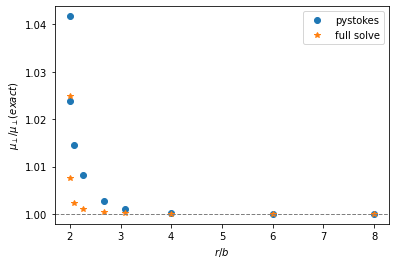

In [16]:
#plt.figure(figsize=(15,4))
plt.plot(rb, pstk_muPerp/muPerp, label='pystokes', marker='o', linestyle="None")
# plt.plot(rb, sp_muPerp/muPerp, label='superposition', marker='^', linestyle="None")
# plt.plot(rb, _2s_muPerp/muPerp, label='2s', marker='s', linestyle="None")
# plt.plot(rb, _3t_muPerp/muPerp, label='3t', marker='d', linestyle="None")
#plt.plot(rb, _3a_muPerp/muPerp, label='3a', marker='+', linestyle="None")
plt.plot(rb, full_muPerp/muPerp, label='full solve', marker='*', linestyle="None")
plt.axhline(y=1., color='grey', linestyle='--', linewidth=1)
plt.xlabel('$r/b$')
plt.ylabel('$\mu_\perp/\mu_\perp(exact)$')
plt.legend()
plt.show()

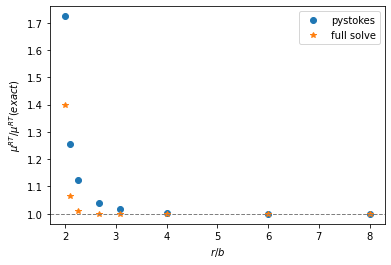

In [17]:
#plt.figure(figsize=(15,4))
plt.plot(rb[1:], pstk_muRT[1:]/muRT[1:], label='pystokes', marker='o', linestyle="None")
# plt.plot(rb, sp_muPerp/muPerp, label='superposition', marker='^', linestyle="None")
# plt.plot(rb, _2s_muPerp/muPerp, label='2s', marker='s', linestyle="None")
# plt.plot(rb, _3t_muPerp/muPerp, label='3t', marker='d', linestyle="None")
#plt.plot(rb, _3a_muPerp/muPerp, label='3a', marker='+', linestyle="None")
plt.plot(rb[1:], full_muRT[1:]/muRT[1:], label='full solve', marker='*', linestyle="None")
plt.axhline(y=1., color='grey', linestyle='--', linewidth=1)
plt.xlabel('$r/b$')
plt.ylabel('$\mu^{RT}/\mu^{RT}(exact)$')
plt.legend()
plt.show()

In [ ]:
## both pystokes and full solve fail to stop the particles at touch